# Trabajo Práctico N°2: NLP
## Chatbot Simple con Spacy y Deep Learning

Este notebook contiene el desarrollo y código de un chatbot simple, implementado con la biblioteca Spacy y técnicas de aprendizaje profundo (Deep Learning), como parte del segundo trabajo práctico de la materia de Procesamiento de Lenguaje Natural (NLP).


### 1. Dependencias

In [7]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

c:\Users\leand\anaconda3\envs\NewBase\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-20 19:48:52 INFO: Downloading default packages for language: es (Spanish) ...
2023-05-20 19:48:53 INFO: File exists: C:\Users\leand\stanza_resources\es\default.zip
2023-05-20 19:48:57 INFO: Finished downloading models and saved to C:\Users\leand\stanza_resources.
2023-05-20 19:48:57 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-05-20 19:48:58 INFO: Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| constitu

### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [8]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [19]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag





dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "Hola Cueva", "Hola Cuevita", "Qué onda?", "Cómo va?", "Buenas", "Buen día", "Buenas tardes", "Buenas noches"],
              "responses": ["Hola! Bienvenido a  La Cuevita, tu agencia de cambio ;)\n Soy Cuevi, cómo puedo ayudarte?"],
             },
             {"tag": "info",
              "patterns": ["Me das info?", "Info", "Información por favor", "Contame cómo es el tema?", "Cómo compro dólares?", "A cúanto está el dólar?", "Quiero comprar",
                           "Quiero vender", "Qué plataformas aceptan?", "Cómo puedo hacer el cambio?", "Cambio", "valor actual"] ,
              "responses": ["Recibimos y enviamos:\n -Efectivo\n -Payoneer\n -Let's Deel\n -Wise\n\nDólar: 480(Compra), 488(Venta)\nUSDT: -5%\nBilletes cara chica -4%"]
             },
             {"tag": "afip",
              "patterns": ["AFIP", "Esto es ilegal", "Los voy a denunciar"],
              "responses": ["eh.. Tomátela ¬¬\n\n **Ha sido bloqueado por el usuario**"]
             },
        
            {"tag": "envios",
              "patterns": ["¿Realizan envios?", "¿Cómo me llega?", "Cómo recibo los pesos?", "A dónde tengo que ir?", "Me llevan a algun lado?"],
              "responses": ["Enviamos a la dirección que nos indiques en el acto. Cubrimos solo CABA."]
             },
            
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [20]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [21]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### 5 - Entrenamiento del modelo

In [22]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (55,) output: 6


In [23]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               7168      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 15,814
Trainable params: 15,814
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
hist = model.fit(x=train_X, y=train_y, epochs=250)


Epoch 1/250
2/2 [==============================] - 0s 6ms/step - loss: 1.8102 - accuracy: 0.1714
Epoch 2/250
2/2 [==============================] - 0s 4ms/step - loss: 1.7560 - accuracy: 0.2286
Epoch 3/250
2/2 [==============================] - 0s 4ms/step - loss: 1.7225 - accuracy: 0.3714
Epoch 4/250
2/2 [==============================] - 0s 4ms/step - loss: 1.6944 - accuracy: 0.3714
Epoch 5/250
2/2 [==============================] - 0s 4ms/step - loss: 1.6826 - accuracy: 0.3429
Epoch 6/250
2/2 [==============================] - 0s 4ms/step - loss: 1.6883 - accuracy: 0.2857
Epoch 7/250
2/2 [==============================] - 0s 5ms/step - loss: 1.7294 - accuracy: 0.2286
Epoch 8/250
2/2 [==============================] - 0s 6ms/step - loss: 1.6187 - accuracy: 0.4571
Epoch 9/250
2/2 [==============================] - 0s 4ms/step - loss: 1.6562 - accuracy: 0.3143
Epoch 10/250
2/2 [==============================] - 0s 4ms/step - loss: 1.6529 - accuracy: 0.4286
Epoch 11/250
2/2 [===========

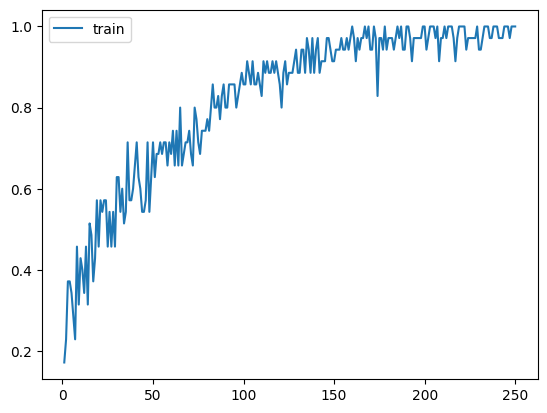

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [26]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [27]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [28]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    


Q: que onda perro
1/1 [==============================] - 0s 51ms/step
BOT: Hola! Bienvenido a  La Cuevita, tu agencia de cambio ;)
 Soy Cuevi, cómo puedo ayudarte?
Q: quiero vender mis dólares ilegales, a cuánto está el cambio?
1/1 [==============================] - 0s 20ms/step
BOT: Recibimos y enviamos:
 -Efectivo
 -Payoneer
 -Let's Deel
 -Wise

Dólar: 480(Compra), 488(Venta)
USDT: -5%
Billetes cara chica -4%
Q: y como es? tengo que ir a algún lugar?
1/1 [==============================] - 0s 21ms/step
BOT: Enviamos a la dirección que nos indiques en el acto. Cubrimos solo CABA.
Q: mmm, medio ilegal esto, mepa que voy a denunciarlos
1/1 [==============================] - 0s 20ms/step
BOT: eh.. Tomátela ¬¬

 **Ha sido bloqueado por el usuario**
Q: Fa, mentira, chau chau
1/1 [==============================] - 0s 17ms/step
BOT: Hasta luego!
Q: 
BOT: Perdón, no comprendo la pregunta.
Q: 
BOT: Perdón, no comprendo la pregunta.
Q: 
BOT: Perdón, no comprendo la pregunta.
